In [1]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections
import pandas as pd
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from pygsp import utils
from pygsp import graphs, filters
from sklearn.linear_model import LinearRegression

In [2]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','CCS':'C','AC5':'L'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

amino_bulkiness = {'A':11.5, 'D':11.68,'C':13.46,'E':13.57,'F':19.8,'G':3.4,'H':13.67,'I':21.4,'K':15.71,'L':21.4,
                   'M':16.25,'N':12.82,'P':17.43,'Q':14.45,'R':14.28,'S':9.47,'T':15.77,'V':21.57,'W':21.61,'Y':18.03}

amino_polarity = {'A':0, 'D':49.7,'C':1.48,'E':49.9,'F':0.35,'G':0,'H':51.6,'I':0.1,'K':49.5,'L':0.13,
                   'M':1.43,'N':3.38,'P':1.58,'Q':3.53,'R':52,'S':1.67,'T':1.66,'V':0.13,'W':2.1,'Y':1.61}

amino_turn_tendency = {'A':0.66, 'D':1.46,'C':1.19,'E':0.74,'F':0.6,'G':1.56,'H':0.95,'I':0.47,'K':1.01,'L':0.59,
                   'M':0.6,'N':1.56,'P':1.52,'Q':0.98,'R':0.95,'S':1.43,'T':0.96,'V':0.5,'W':0.96,'Y':1.14}

amino_coil_tendency = {'A':0.71, 'D':1.21,'C':1.19,'E':0.84,'F':0.71,'G':1.52,'H':1.07,'I':0.66,'K':0.99,'L':0.69,
                   'M':0.59,'N':1.37,'P':1.61,'Q':0.87,'R':1.07,'S':1.34,'T':1.08,'V':0.63,'W':0.76,'Y':1.07}

amino_flexibility = {'A':0, 'D':2,'C':1,'E':3,'F':2,'G':0,'H':2,'I':2,'K':4,'L':2,
                   'M':3,'N':2,'P':0,'Q':3,'R':5,'S':1,'T':1,'V':1,'W':2,'Y':2}

amino_partial_specific_volume = {'A':60.46, 'D':73.83,'C':67.7,'E':85.88,'F':121.48,'G':43.25,'H':98.79,
                                 'I':107.72,'K':108.5,
                                 'L':107.75,'M':105.35,'N':78.01,'P':82.83,'Q':93.9,
                                 'R':127.34,'S':60.62,'T':76.83,'V':90.78,'W':143.91,'Y':123.6}

amino_compressibility = {'A':-25.5, 'D':-33.12,'C':-32.82,'E':-36.17,'F':-34.54,'G':-27,'H':-31.84,
                        'I':-31.78,'K':-32.4,
                        'L':-31.78,'M':-31.18,'N':-30.9,'P':-23.25,'Q':-32.6,
                        'R':-26.62,'S':-29.88,'T':-31.23,'V':-30.62,'W':-30.24,'Y':-35.01}

amino_refractive_index = {'A':14.34, 'D':12,'C':35.77,'E':17.26,'F':29.4,'G':0,'H':21.81,
                        'I':19.06,'K':21.29,
                        'L':18.78,'M':21.64,'N':13.28,'P':10.93,'Q':17.56,
                        'R':26.66,'S':6.35,'T':11.01,'V':13.92,'W':42.53,'Y':31.55}

In [ ]:
# amino_compressibility = {'A':, 'D':,'C':,'E':,'F':,'G':,'H':,
#                         'I':,'K':,
#                         'L':,'M':,'N':,'P':,'Q':,
#                         'R':,'S':,'T':,'V':,'W':,'Y':}

In [3]:
def crawl_pdb(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        try:
            info['coords'] = coords
            info['distance_matrix'] = distance_matrix
    #         print(np.unique(labels))
            info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
    #         print(info['sequence'])
            pdbinfo_dict[pdb] = info
        except:
            pass
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
#     print(distance_matrix.shape)
    G = graphs.Graph(distance_matrix)
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, pdb,signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'bulkiness':
        s = np.asarray([amino_bulkiness[aa] for aa in seq])
    elif signal == 'polarity':
        s = np.asarray([amino_polarity[aa] for aa in seq])
    elif signal == 'turn_tendency':
        s = np.asarray([amino_turn_tendency[aa] for aa in seq])
    elif signal == 'coil_tendency':
        s = np.asarray([amino_coil_tendency[aa] for aa in seq])
    elif signal == 'flexibility':
        s = np.asarray([amino_flexibility[aa] for aa in seq])
    elif signal == 'partial_specific_volume':
        s = np.asarray([amino_partial_specific_volume[aa] for aa in seq])
    elif signal == 'compressibility':
        s = np.asarray([amino_compressibility[aa] for aa in seq])
    elif signal == 'refractive_index':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'conservation_score':
        #https://compbio.cs.princeton.edu/conservation/
        filename = pdb.split('.')[0]
#         cmd = ['python3 ./pdb2fasta-master/pdb2fasta.py '+pdb_path+''+pdb+' > ./pdb2fasta-master/'+filename+'.fasta']
#         print(cmd)
#         process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open('./pdb2fasta-master/'+filename+'.fasta', 'w') as the_file:
            the_file.write('>'+filename+':A\n'+seq+"-")
        process = 0
        if process ==0:
            s = []
            cmd = ['python2 ./pdb2fasta-master/conservation_code/score_conservation.py -alignfile ./pdb2fasta-master/'+filename+'.fasta > ./pdb2fasta-master/'+filename+'.csv']
#             print(cmd)
            process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if process ==0:
                with open('./pdb2fasta-master/'+filename+'.csv') as f:
                    for i in range(5):
                        next(f)
                    for line in f:
#                         print(line.split("\t")[1])
                        s.append(float(line.split("\t")[1]))
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s


def get_cutoff(signal,G):
    coeff = []
    cutoff = []
    for i in range(20,90,10):
        p = np.percentile(signal, i) 
#         print(p)
        signal[np.where(signal<p)] = 0
#         print(np.corrcoef(signal,G.e))
        coeff.append(np.corrcoef(signal,G.lmax*G.e)[0,1])
        cutoff.append(i)
#     print("coeff",coeff)
    cutoff = cutoff[np.argmax(coeff)]
    return cutoff

def get_filtered_signal(G, signal, cutoff,type_spatial):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                cutof= get_cutoff(signal_filtered_hat[:,j],G)
                p=np.percentile(signal_filtered_hat[:,j],cutoff) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
        signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        return signal_filtered_hat

In [4]:
signals_and_cutoffs = {'molecular_weight': 0.42, 
                       'hydrophobicity': 0.42, 
                       'node_degree': 0.42, 
                       'node_weighted_degree': 0.42, 
                       'residue_count': 0.42, 
                       'clustering_coeff': 0.42,
                      'conservation_score': 0.42}

signals_wavelet = []
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','conservation_score','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility']
for i in signals:
    for j in range(1,5):
        signals_wavelet.append(i+"_"+str(j))

In [18]:
def crawl_pdb_solubility(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
#     print(pdb_files)
    for pdb in pdb_files:
        info = dict()
#         print(path + pdb)
        structure = parser.get_structure('pdb_file', path + pdb ) # + '/' + pdb + '.pdb'
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        assert residue.get_resname() not in ['HOH', ' CA']
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())

                    except :
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        try:
            info[id] = pdb
            info['coords'] = coords
            info['distance_matrix'] = distance_matrix
            info['sequence'] = ''.join([amino_lookup[s] for s in labels])
            pdbinfo_dict[pdb] = info
        except:
            pass
    return pdbinfo_dict


In [19]:
path = '../Protein-GSP-master/data/solubility_data/'
pdbinfo_dict = crawl_pdb_solubility(path)

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5676.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5708.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5740.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5842.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2822.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6107.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6154.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2384.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2412.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2448.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6283.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6298.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6313.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6348.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2912.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12151.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12154.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12157.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12984.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14241.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10803.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10851.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10899.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10947.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10995.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2363.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2488.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17575.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 17678.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5236.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureB

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9778.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9820.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9862.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9904.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9915.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15391.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15614.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 15837.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 16060.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16283.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9776.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9782.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9788.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9794.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9800.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7520.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7530.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7540.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7550.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7560.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5257.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5260.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5261.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5264.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5269.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7143.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7159.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7169.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7612.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 30410.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9267.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9283.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6008.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6056.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6104.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6115.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6158.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6177.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6469.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12585.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7620.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7632.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7648.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7656.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 7672.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 62109.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 62137.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 62165.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 62193.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 62221.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structu

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5945.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5969.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5993.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6017.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6166.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7222.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7238.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7254.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7531.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5589.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6377.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6420.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6463.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6786.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3151.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8078.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8171.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4092.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4217.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7119.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10771.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10868.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10969.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4218.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4296.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Structure

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6929.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7141.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2936.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2948.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2960.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5782.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5836.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5890.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6316.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5939.
  PDBConstructionWarning,
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/StructureBui

In [10]:
len(pdbinfo_dict.keys())

267

In [16]:
solubility_ground = pd.read_csv("../Protein-GSP-master/data/solubility_percentage.txt",sep="\t")
solubility_ground['pdb'] = "pdb"+solubility_ground['pdb'].str.lower()+".ent" 
solubility_ground.index = solubility_ground['pdb']
solubility_ground['Solubility(%)'] = solubility_ground['Solubility(%)'].astype('int')
solubility_ground = solubility_ground.drop_duplicates(subset=['pdb'])

In [43]:
solubility_ground.to_csv("../Protein-GSP-master/data/solubility_percentage_new.txt")

In [23]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#     print(pdb)
#         print (pdb, end=', ')
    try:
        row = []
        c = solubility_ground.loc[pdb,'Solubility(%)']
    #     if solubility_ground.loc[pdb,'Solubility(%)']>44: c = 1
    #     elif solubility_ground.loc[pdb,'Solubility(%)']<=44: c= 0
        G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
        for signal_name in signals:
            signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
            value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')   
    #         print(value)
            row.extend(value)
        row.append(c)
        gsp_features.loc[pdb] = row
    except:
        continue

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

0.5060109837915819


In [24]:
from scipy import stats
f_corr = pd.DataFrame()
for i in range(X.shape[1]):
    f_corr.loc[X.columns[i],'corr'] = stats.spearmanr(X.iloc[:,i],y)[0]

In [26]:
f_corr.to_csv("./correlation_solubility.txt")

### gsp_features

In [14]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

In [15]:
a_series = (gsp_features != 0).any(axis=1)
gsp_features = gsp_features.loc[a_series]
print(gsp_features.shape)
for i in range(gsp_features.shape[0]):
    if gsp_features.iloc[i]['class']>64: gsp_features.iloc[i]['class'] = 1
    else: gsp_features.iloc[i]['class'] = 0

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

(267, 61)


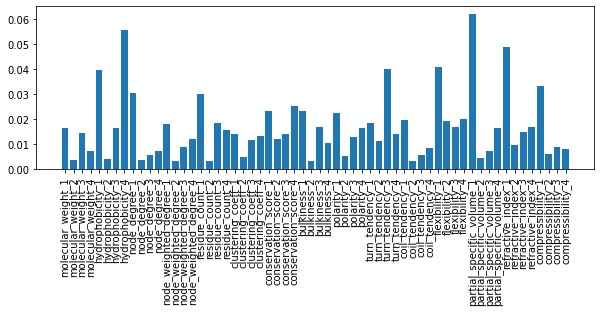

Accuracy: 0.03 (+/- 0.00)


In [16]:
# Cutoff=10
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
        # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
# import matplotlib.pyplot as plt

# f, ax = plt.subplots(figsize=(10,3))
# importance = model.feature_importances_
# # summarize feature importance
# # for i,v in enumerate(importance):
# # 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# y_pos = np.arange(X.shape[1])
# pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
# pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [129]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Linear Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Ridge Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Lasso Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = ElasticNet(alpha = 0.01)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Elastic Net Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = RandomForestRegressor(n_estimators=1000)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Random Forest Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = SVR(C=1.0, epsilon=0.2)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("SVR Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))

lr = DecisionTreeRegressor(random_state=0)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("Decision tree Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))


lr = KNeighborsRegressor(n_neighbors=5)
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)

pred_test_lr= lr.predict(X_test)
print("KNN Regressor")
print("RMSE",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("r2",r2_score(y_test, pred_test_lr))


Linear Regressor
RMSE 0.5152534158600448
r2 -0.19468737149949944
Ridge Regressor
RMSE 0.46373500719342875
r2 0.03227429396489745
Lasso Regressor
RMSE 0.4707562262726256
r2 0.002748589415004332
Elastic Net Regressor
RMSE 0.46898175093885314
r2 0.010252527788473631
Random Forest Regressor
RMSE 0.4683008519630228
r2 0.013124404228181397
SVR Regressor
RMSE 0.5111901204752908
r2 -0.1759190267219406
Decision tree Regressor
RMSE 0.6876851950248617
r2 -1.1280991735537191
KNN Regressor
RMSE 0.5497474167490214
r2 -0.3600000000000003


In [71]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  
scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=9)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))

    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import matthews_corrcoef
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
    # clf.fit(X_train, y_train) 

    y_pred = clf.predict(X_test)
    print("MCC score : ",matthews_corrcoef(y_test, y_pred))

# lr_probs = clf.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]

# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr, tpr, _ = roc_curve(y_test, lr_probs)
# roc_auc = auc(fpr, tpr)

# # print("AUC : ",roc_auc_score(y_test, y_pred, multi_class='ovr'))
# lw = 2
# plt.figure()
# plt.style.use('seaborn')
# plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.show()


ACCURACY OF THE MODEL:  0.7777777777777778
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        14
         1.0       0.77      0.77      0.77        13

    accuracy                           0.78        27
   macro avg       0.78      0.78      0.78        27
weighted avg       0.78      0.78      0.78        27

AUCROC 0.7774725274725275
MCC score :  0.554945054945055

ACCURACY OF THE MODEL:  0.8148148148148148
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83        14
         1.0       0.83      0.77      0.80        13

    accuracy                           0.81        27
   macro avg       0.82      0.81      0.81        27
weighted avg       0.82      0.81      0.81        27

AUCROC 0.8131868131868133
MCC score :  0.6298438669252061

ACCURACY OF THE MODEL:  0.7777777777777778
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79 

In [72]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.78,0.78,0.74,0.81,0.81]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

Accuracy: 0.79 (+/- 0.04)
MCC: 0.58 (+/- 0.07)
ROC AUC: 0.79 (+/- 0.03)
f1: 0.78 (+/- 0.05)


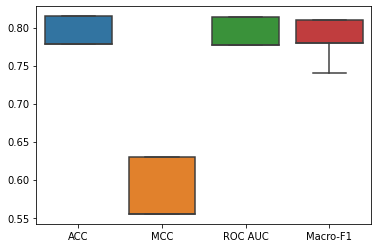

In [73]:
import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [74]:
data

,ACC,MCC,ROC AUC,Macro-F1
0,0.777778,0.554945,0.777473,0.78
1,0.814815,0.629844,0.813187,0.78
2,0.777778,0.554945,0.777473,0.74
3,0.777778,0.554945,0.777473,0.81
4,0.814815,0.629844,0.813187,0.81


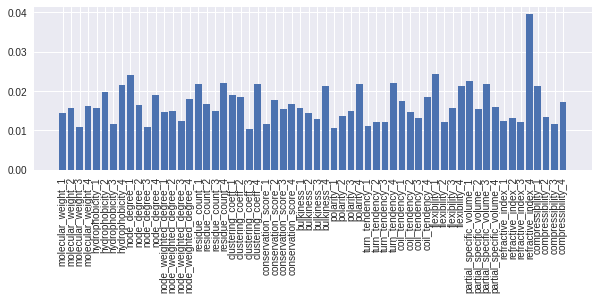

Accuracy: 0.81
0.014814814814814791


In [153]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestClassifier(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=9)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f" % (scores.mean()))
print(scores.std())

In [154]:
final_data = pd.DataFrame(columns = ['Wavelet Scales','Feature Score','Feature Importance','group'])
# final_data.columns = ['Wavelet Scales','Feature Score','Feature Importance','Feature']
k=0
for i,j in zip(importance,signals_wavelet):
#     print(j.rpartition("_"))
    final_data.loc[k,'Wavelet Scales'] = j.rpartition("_")[2]
    final_data.loc[k,'group'] = j.rpartition("_")[0]
    final_data.loc[k,'Feature Score'] = i
    final_data.loc[k,'Feature Importance'] = i
    k=k+1
final_data.to_csv("./feature_importance_solubility.txt",sep="\t",index=False)

In [77]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = SVC(kernel = 'poly')

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))


ACCURACY OF THE MODEL:  0.5555555555555556
              precision    recall  f1-score   support

         0.0       0.67      0.29      0.40        28
         1.0       0.52      0.85      0.65        26

    accuracy                           0.56        54
   macro avg       0.60      0.57      0.52        54
weighted avg       0.60      0.56      0.52        54

AUCROC 0.5659340659340659

ACCURACY OF THE MODEL:  0.5740740740740741
              precision    recall  f1-score   support

         0.0       0.44      0.38      0.41        21
         1.0       0.64      0.70      0.67        33

    accuracy                           0.57        54
   macro avg       0.54      0.54      0.54        54
weighted avg       0.56      0.57      0.57        54

AUCROC 0.538961038961039

ACCURACY OF THE MODEL:  0.5925925925925926
              precision    recall  f1-score   support

         0.0       0.58      0.58      0.58        26
         1.0       0.61      0.61      0.61        28


In [79]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.52,0.54,0.59,0.58,0.58]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

Accuracy: 0.59 (+/- 0.04)
MCC: 0.17 (+/- 0.11)
ROC AUC: 0.58 (+/- 0.05)
f1: 0.56 (+/- 0.05)


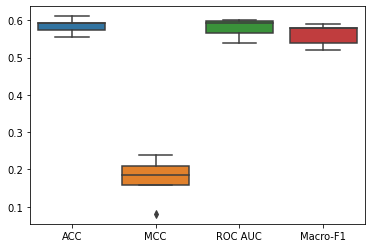

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = LogisticRegression()
scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))   

/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear


ACCURACY OF THE MODEL:  0.7037037037037037
              precision    recall  f1-score   support

         0.0       0.58      0.75      0.65        20
         1.0       0.82      0.68      0.74        34

    accuracy                           0.70        54
   macro avg       0.70      0.71      0.70        54
weighted avg       0.73      0.70      0.71        54

AUCROC 0.7132352941176471

ACCURACY OF THE MODEL:  0.7592592592592593
              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76        29
         1.0       0.71      0.80      0.75        25

    accuracy                           0.76        54
   macro avg       0.76      0.76      0.76        54
weighted avg       0.76      0.76      0.76        54

AUCROC 0.7620689655172413

ACCURACY OF THE MODEL:  0.6481481481481481
              precision    recall  f1-score   support

         0.0       0.57      0.74      0.64        23
         1.0       0.75      0.58      0.65        31

/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

Accuracy: 0.67 (+/- 0.11)
MCC: 0.35 (+/- 0.20)
ROC AUC: 0.68 (+/- 0.11)
f1: 0.67 (+/- 0.11)


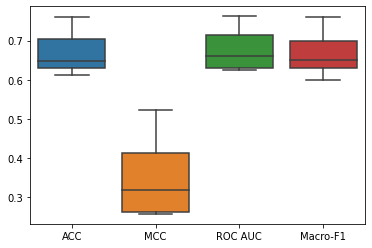

In [86]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.70,0.76,0.65,0.60,0.63]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [87]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = GaussianNB()

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))   


ACCURACY OF THE MODEL:  0.6851851851851852
              precision    recall  f1-score   support

         0.0       0.75      0.56      0.64        27
         1.0       0.65      0.81      0.72        27

    accuracy                           0.69        54
   macro avg       0.70      0.69      0.68        54
weighted avg       0.70      0.69      0.68        54

AUCROC 0.6851851851851852

ACCURACY OF THE MODEL:  0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.71      0.61      0.65        28
         1.0       0.63      0.73      0.68        26

    accuracy                           0.67        54
   macro avg       0.67      0.67      0.67        54
weighted avg       0.67      0.67      0.67        54

AUCROC 0.668956043956044

ACCURACY OF THE MODEL:  0.5925925925925926
              precision    recall  f1-score   support

         0.0       0.80      0.39      0.52        31
         1.0       0.51      0.87      0.65        23


Accuracy: 0.63 (+/- 0.09)
MCC: 0.28 (+/- 0.17)
ROC AUC: 0.63 (+/- 0.09)
f1: 0.61 (+/- 0.12)


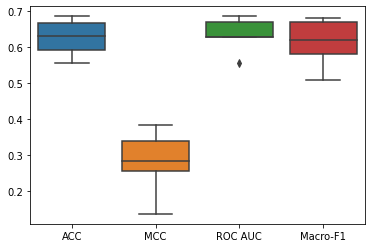

In [88]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.68,0.67,0.58,0.62,0.51]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf =  KNeighborsClassifier(n_neighbors=5)


scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))   


ACCURACY OF THE MODEL:  0.5925925925925926
              precision    recall  f1-score   support

         0.0       0.46      0.65      0.54        20
         1.0       0.73      0.56      0.63        34

    accuracy                           0.59        54
   macro avg       0.60      0.60      0.59        54
weighted avg       0.63      0.59      0.60        54

AUCROC 0.6044117647058823

ACCURACY OF THE MODEL:  0.6481481481481481
              precision    recall  f1-score   support

         0.0       0.54      0.62      0.58        21
         1.0       0.73      0.67      0.70        33

    accuracy                           0.65        54
   macro avg       0.64      0.64      0.64        54
weighted avg       0.66      0.65      0.65        54

AUCROC 0.6428571428571428

ACCURACY OF THE MODEL:  0.6481481481481481
              precision    recall  f1-score   support

         0.0       0.72      0.60      0.65        30
         1.0       0.59      0.71      0.64        24

Accuracy: 0.61 (+/- 0.11)
MCC: 0.22 (+/- 0.26)
ROC AUC: 0.61 (+/- 0.13)
f1: 0.61 (+/- 0.13)


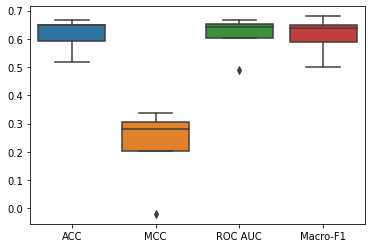

In [99]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.59,0.64,0.65,0.50,0.68]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [101]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = AdaBoostClassifier(n_estimators=1000, random_state=109)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
  
    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))   

ACCURACY OF THE MODEL:  0.6296296296296297
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55        22
         1.0       0.69      0.69      0.69        32

    accuracy                           0.63        54
   macro avg       0.62      0.62      0.62        54
weighted avg       0.63      0.63      0.63        54

AUCROC 0.6164772727272727
ACCURACY OF THE MODEL:  0.6111111111111112
              precision    recall  f1-score   support

         0.0       0.57      0.64      0.60        25
         1.0       0.65      0.59      0.62        29

    accuracy                           0.61        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.62      0.61      0.61        54

AUCROC 0.613103448275862
ACCURACY OF THE MODEL:  0.7222222222222222
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72        25
         1.0       0.77      0.69      0.73        29

  

Accuracy: 0.61 (+/- 0.12)
MCC: 0.22 (+/- 0.26)
ROC AUC: 0.61 (+/- 0.13)
f1: 0.61 (+/- 0.13)


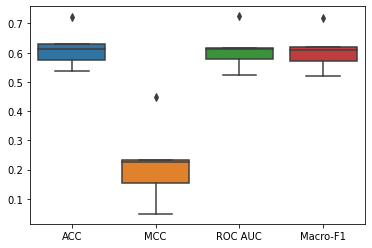

In [102]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.62,0.61,0.72,0.52,0.57]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)

In [103]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, random_state=109)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))  

ACCURACY OF THE MODEL:  0.6481481481481481
              precision    recall  f1-score   support

         0.0       0.57      0.70      0.63        23
         1.0       0.73      0.61      0.67        31

    accuracy                           0.65        54
   macro avg       0.65      0.65      0.65        54
weighted avg       0.66      0.65      0.65        54

AUCROC 0.6542776998597475
ACCURACY OF THE MODEL:  0.6481481481481481
              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61        25
         1.0       0.67      0.69      0.68        29

    accuracy                           0.65        54
   macro avg       0.65      0.64      0.65        54
weighted avg       0.65      0.65      0.65        54

AUCROC 0.6448275862068966
ACCURACY OF THE MODEL:  0.5740740740740741
              precision    recall  f1-score   support

         0.0       0.59      0.57      0.58        28
         1.0       0.56      0.58      0.57        26

 

Accuracy: 0.66 (+/- 0.12)
MCC: 0.33 (+/- 0.25)
ROC AUC: 0.66 (+/- 0.12)
f1: 0.66 (+/- 0.12)


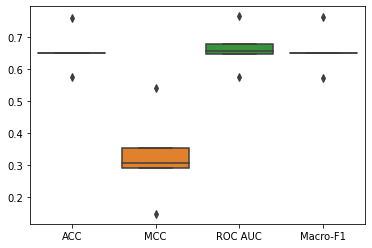

In [104]:
scores_acc = np.array(scores_acc)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))
scores_mcc = np.array(scores_mcc)
print("MCC: %0.2f (+/- %0.2f)" % (scores_mcc.mean(), scores_mcc.std() * 2))
scores_auroc = np.array(scores_auroc)
print("ROC AUC: %0.2f (+/- %0.2f)" % (scores_auroc.mean(), scores_auroc.std() * 2))
scores_f1 = [0.65,0.65,0.57,0.76,0.65]
scores_f1 = np.array(scores_f1)
print("f1: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

import seaborn as sns
data = pd.DataFrame()
data['ACC'] = scores_acc
data['MCC'] = scores_mcc
data['ROC AUC'] = scores_auroc
data['Macro-F1'] = scores_f1
ax = sns.boxplot(data=data)